In [1]:
import numpy as np
from qiskit import Aer, execute, QuantumCircuit, IBMQ, ClassicalRegister, QuantumRegister
from qiskit.compiler import transpile, assemble
from qiskit.extensions import Initialize
from qiskit_textbook.tools import random_state
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *

provider=IBMQ.load_account()

In [2]:
qr= QuantumRegister(3, name= 'q')
crx= ClassicalRegister(1, name='crx')
crz= ClassicalRegister(1, name='crz')
qc= QuantumCircuit(qr, crx, crz)

In [3]:
def form_bell_pair(qc, a, b):
    qc.h(a)
    qc.cx(a,b)

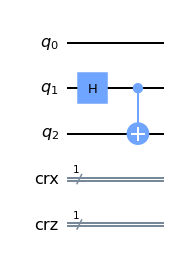

In [4]:
#first we create an entangled pair. 
#q1 stays with Alice and q2 goes to BOB
form_bell_pair(qc, 1, 2)
qc.draw()

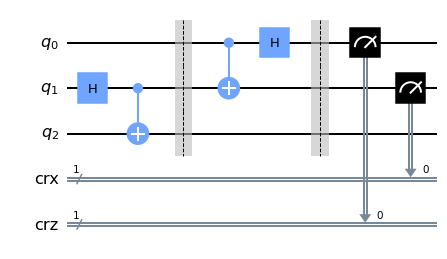

In [5]:
#encoding
qc.barrier()
qc.cx(0, 1)
qc.h(0)

#decoding
qc.barrier()
qc.measure(0, crz)
qc.measure(1, crx)
qc.draw()

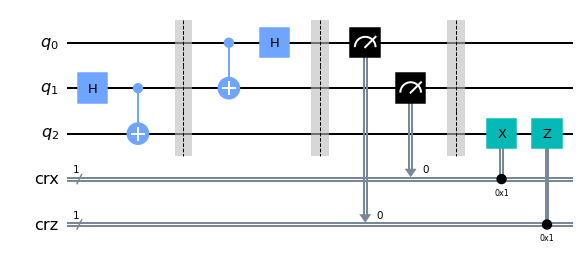

In [6]:
#retrieving
qc.barrier()
qc.x(2).c_if(crx, 1)
qc.z(2).c_if(crz, 1)
qc.draw()

<IPython.core.display.Latex object>

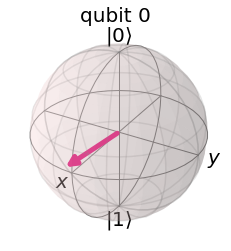

In [7]:
#evaluating our protocol
psi= random_state(1)
display(array_to_latex(psi, prefix='|\\psi\\rangle='))
plot_bloch_multivector(psi)

In [8]:
init_gate=Initialize(psi)
init_gate.label= 'init'

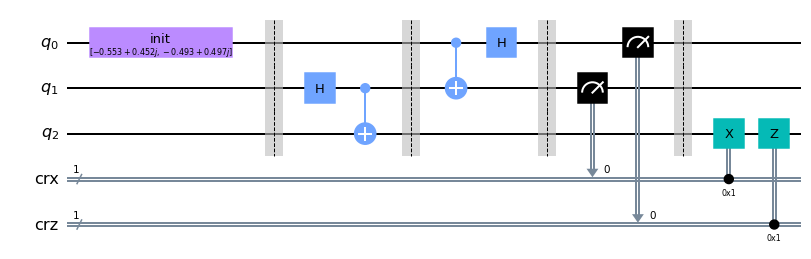

In [9]:
##Redrawing our circuit for better understanding

qr= QuantumRegister(3, name= 'q')
crx= ClassicalRegister(1, name='crx')
crz= ClassicalRegister(1, name='crz')
qc= QuantumCircuit(qr, crx, crz)

qc.append( init_gate, [0])
qc.barrier()

#entanglement
form_bell_pair(qc, 1, 2)
qc.barrier()

#encoding
qc.cx(0, 1)
qc.h(0)

#decoding
qc.barrier()
qc.measure(1, crx)
qc.measure(0, crz)
qc.draw()

#extracting
#retrieving
qc.barrier()
qc.x(2).c_if(crx, 1)
qc.z(2).c_if(crz, 1)
qc.draw()

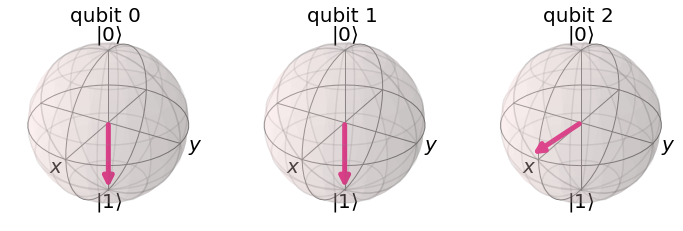

In [10]:
backend= Aer.get_backend('aer_simulator')
qc.save_statevector()
result= backend.run(qc).result().get_statevector()
plot_bloch_multivector(result)

In [11]:
##Next using QASM_simulator
inverse_init_gate=init_gate.gates_to_uncompute()
inverse_init_gate.label='disentangler'

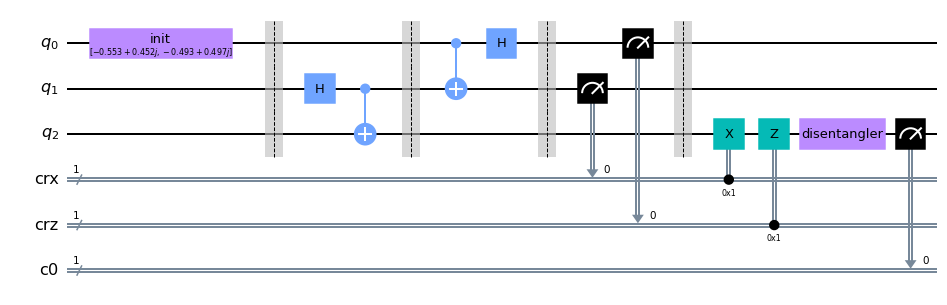

In [12]:
##Redrawing our circuit for better understanding

qr= QuantumRegister(3, name= 'q')
crx= ClassicalRegister(1, name='crx')
crz= ClassicalRegister(1, name='crz')
qc= QuantumCircuit(qr, crx, crz)

qc.append( init_gate, [0])
qc.barrier()

#entanglement
form_bell_pair(qc, 1, 2)
qc.barrier()

#encoding
qc.cx(0, 1)
qc.h(0)

#decoding
qc.barrier()
qc.measure(1, crx)
qc.measure(0, crz)
qc.draw()

#extracting
#retrieving
qc.barrier()
qc.x(2).c_if(crx, 1)
qc.z(2).c_if(crz, 1)
qc.append(inverse_init_gate, [2])

c_result= ClassicalRegister(1)
qc.add_register(c_result)
qc.measure(2,2)
qc.draw()

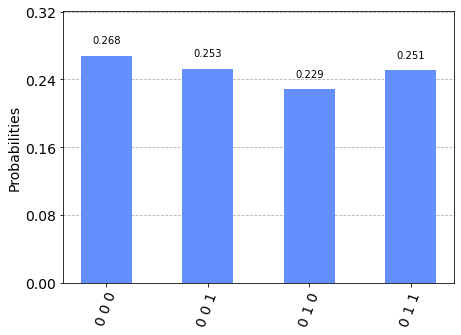

In [13]:
t_qc= transpile(qc, backend)
t_qc.save_statevector()
result=backend.run(t_qc).result().get_counts()
plot_histogram(result)

In [14]:
##SO far we have only used simulator
##to run on actual hardware we need to make serious changes as hardware doesnt perfrom operations 
#> after measurement has been made,
##PS: Measurement operations right in between the cicuit

##Solution: deferred measurements

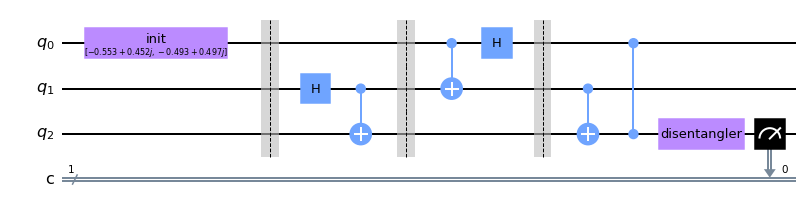

In [15]:
qc=QuantumCircuit(3,1)

qc.append( init_gate, [0])
qc.barrier()

#entanglement
form_bell_pair(qc, 1, 2)
qc.barrier()

#encoding
qc.cx(0, 1)
qc.h(0)
qc.barrier()

#deferring measurements
qc.cx(1,2)
qc.cz(0,2)

qc.append(inverse_init_gate, [2])

qc.measure(2,0)
qc.draw()

In [16]:
#executing hardware
IBMQ.load_account()
provider=IBMQ.get_provider( hub='ibm-q')

ibmqfactory.load_account:WARNING:2021-12-11 18:45:00,453: Credentials are already in use. The existing account in the session will be replaced.


In [17]:
##of that, we get the least strained hardware and run our circuit over it
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor

backend= least_busy(provider.backends( filters= lambda b: b.configuration().n_qubits >=3 and
                                      not b.configuration().simulator and b.status().operational== True))

t_qc=transpile(qc, backend, optimization_level=3)
job= backend.run(t_qc)
job_monitor(job)   

                 

Job Status: job has successfully run


{'0': 3339, '1': 661}


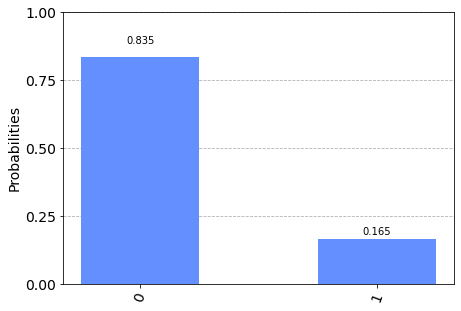

In [18]:
exp_count=job.result().get_counts(qc)
print(exp_count)
plot_histogram(exp_count)

In [19]:
print(f" the experimental error rate is : {exp_count['1']/sum(exp_count.values()) :.3f}%")

 the experimental error rate is : 0.165%


In [20]:
##lastly
# backend: ibmq_belem
# Validating: 795ms
# In queue: 3m 42s
# Running: 32.1s
# time in system 4.6s